In [1]:
import numpy as np
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
data = pd.read_csv('/home/ibrahim/Desktop/covid-19/time_series_covid_19_confirmed.csv')
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,22,22,24,24,40,40,74,84,94
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,55,59,64,70,76,89,104,123,146,174
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,60,74,87,90,139,201,230,264,302,367
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,39,39,53,75,88,113,133,164,188,224
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,1,2,2,3,3,3,4


### US

In [676]:
nums = data[data['Country/Region']=='US'].sum().drop(['Province/State','Country/Region','Lat','Long'])
#nums = data[data['Country/Region']=='US'].sum().drop(['Lat','Long'])

In [677]:
y = data[data['Country/Region']=='US'].sum().drop(['Province/State','Country/Region','Lat','Long']).tolist()
x = range(len(y))

### All Countries

In [3]:
nums = data[:].sum().drop(['Lat','Long'])
#nums = data[data['Country/Region']=='US'].sum().drop(['Lat','Long'])

y = data[:].sum().drop(['Lat','Long']).tolist()
x = range(len(y))

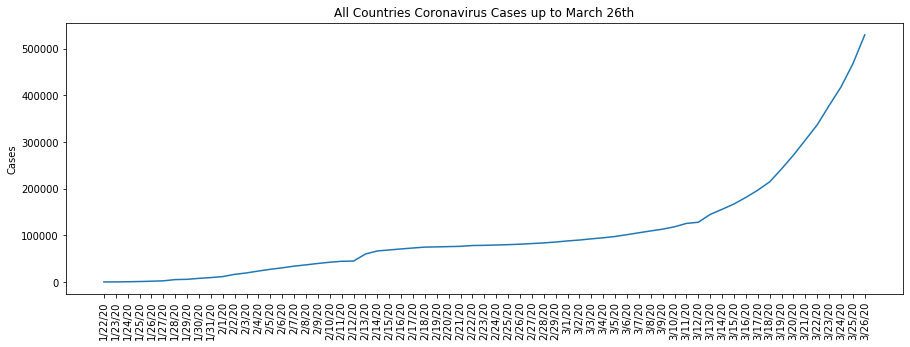

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,5))
plt.plot(nums)
plt.xticks(rotation=90)
plt.ylabel('Cases')
plt.title("All Countries Coronavirus Cases up to March 26th")
plt.show()

# InfectionRateNet 

In [9]:
import torch
from torch import nn
import numpy as np
import copy
from pylab import *
from torch.autograd import Variable


In [11]:

features = np.expand_dims(np.arange(65), 1) + 1
features = features.astype(np.float)

y = data[:].sum().drop(['Lat','Long']).tolist()

targets = np.expand_dims(np.array(y), 1)
targets = targets.astype(np.float)

fstd = np.std(features.flatten())
fmean = np.mean(features.flatten())


x = Variable(torch.from_numpy(features))
y = Variable(torch.from_numpy(targets))

y = torch.log(y)

tstd = torch.std(y)
tmean = torch.mean(y)

x = (x - fmean) / fstd
y = (y - tmean) / tstd

class InfectionRateNet(torch.nn.Module):
    def __init__(self):
        super(InfectionRateNet, self).__init__()
#         a = np.random.normal(scale = 1 / np.sqrt(3), size = 1)
#         b = np.random.normal(scale = 1 / np.sqrt(3), size = 1)
        a = np.array([0.1313])
        b  = np.array([0.7547])
        self.a = nn.Parameter(torch.tensor(a))
        self.b = nn.Parameter(torch.tensor(b))
        
    def forward(self, x):
        self.r_naught = torch.pow( self.a, (x - self.b) )
        x = self.r_naught
        return x

net = InfectionRateNet()

lr=0.0001  #0.0001
epochs = 100_000


optimizer = torch.optim.SGD(net.parameters(), lr=lr)
criterion = torch.nn.L1Loss()
# criterion = torch.nn.SmoothL1Loss() 


for t in range(epochs):
    y_hat = net(x)

    loss = criterion(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    if t%10000 == 0:
        print(t, '/ Loss=', loss.data.numpy())
    

0 / Loss= 22.44049002508822
10000 / Loss= 0.8575818038562475
20000 / Loss= 0.7035333558042243
30000 / Loss= 0.5682300812498846
40000 / Loss= 0.4946292971389458
50000 / Loss= 0.4624968660861808
60000 / Loss= 0.44964539231886413
70000 / Loss= 0.44321940335415466
80000 / Loss= 0.43743713753425384
90000 / Loss= 0.4329177068983427


In [12]:
model_state = {
        'state_dict': net.state_dict(),
    }
       
chkpnt_path = 'r_naught_covid19_cases_pred_net.pth'
torch.save(model_state, chkpnt_path)

# Eval

In [13]:
# net_eval = copy.deepcopy(net)
net_eval = net.eval()

for p in net_eval.parameters():
    p.requires_grad = False
    
net.children

<bound method Module.children of InfectionRateNet()>

In [17]:
net.a, net.b

(Parameter containing:
 tensor([2.6119], dtype=torch.float64),
 Parameter containing:
 tensor([1.4169], dtype=torch.float64))

In [18]:
for p in net_eval.parameters():
    print(p)

Parameter containing:
tensor([2.6119], dtype=torch.float64)
Parameter containing:
tensor([1.4169], dtype=torch.float64)


/home/ibrahim/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


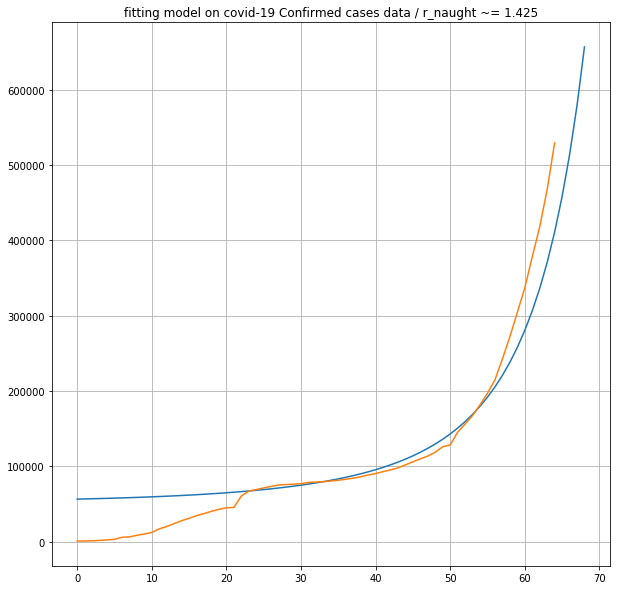

In [22]:
preds = []


for i in range(1,70):
    
    inp_x = i
    inp_x = (inp_x - fmean) / fstd
    inp_x = torch.tensor([inp_x])
    inp_x = inp_x.type(torch.DoubleTensor)

    
    out_pred = net_eval(inp_x)
    
    out_pred = (out_pred * tstd) + tmean
    out_pred = torch.exp(torch.tensor(out_pred))

    preds.append(out_pred)

figure(figsize=(10,10))

title('fitting model on covid-19 Confirmed cases data / r_naught ~= '+str(1.425))
grid()
plot(preds)
plot(targets)

In [662]:
# torch.exp((y * tstd) + tmean)

# Formula:   $y=a^{(x-b)}$


In [682]:
 

ff = 0
r_naught = net_eval.a.data.numpy()[0]
b = net_eval.b.data.numpy()[0]
for f in np.arange(1, 70):
    inp = (f - fmean) / fstd
    out = r_naught ** (inp - b)
    out = (out * tstd) + tmean
    possible_infections = np.exp(out) 
#     ff += infect_rate
    
    print(possible_infections)
    
#     print(f, ff ** r_naught)

tensor(98.7384, dtype=torch.float64)
tensor(99.0528, dtype=torch.float64)
tensor(99.3959, dtype=torch.float64)
tensor(99.7705, dtype=torch.float64)
tensor(100.1796, dtype=torch.float64)
tensor(100.6264, dtype=torch.float64)
tensor(101.1148, dtype=torch.float64)
tensor(101.6487, dtype=torch.float64)
tensor(102.2327, dtype=torch.float64)
tensor(102.8717, dtype=torch.float64)
tensor(103.5714, dtype=torch.float64)
tensor(104.3379, dtype=torch.float64)
tensor(105.1781, dtype=torch.float64)
tensor(106.0997, dtype=torch.float64)
tensor(107.1113, dtype=torch.float64)
tensor(108.2227, dtype=torch.float64)
tensor(109.4448, dtype=torch.float64)
tensor(110.7898, dtype=torch.float64)
tensor(112.2715, dtype=torch.float64)
tensor(113.9059, dtype=torch.float64)
tensor(115.7107, dtype=torch.float64)
tensor(117.7064, dtype=torch.float64)
tensor(119.9164, dtype=torch.float64)
tensor(122.3675, dtype=torch.float64)
tensor(125.0906, dtype=torch.float64)
tensor(128.1215, dtype=torch.float64)
tensor(131.5019,

# Day >> number of cases 

In [680]:
list(zip((np.arange(len(preds) )+1), preds ))

[(1, tensor([98.7384], dtype=torch.float64)),
 (2, tensor([99.0528], dtype=torch.float64)),
 (3, tensor([99.3959], dtype=torch.float64)),
 (4, tensor([99.7705], dtype=torch.float64)),
 (5, tensor([100.1796], dtype=torch.float64)),
 (6, tensor([100.6264], dtype=torch.float64)),
 (7, tensor([101.1148], dtype=torch.float64)),
 (8, tensor([101.6487], dtype=torch.float64)),
 (9, tensor([102.2327], dtype=torch.float64)),
 (10, tensor([102.8717], dtype=torch.float64)),
 (11, tensor([103.5714], dtype=torch.float64)),
 (12, tensor([104.3379], dtype=torch.float64)),
 (13, tensor([105.1781], dtype=torch.float64)),
 (14, tensor([106.0997], dtype=torch.float64)),
 (15, tensor([107.1113], dtype=torch.float64)),
 (16, tensor([108.2227], dtype=torch.float64)),
 (17, tensor([109.4448], dtype=torch.float64)),
 (18, tensor([110.7898], dtype=torch.float64)),
 (19, tensor([112.2715], dtype=torch.float64)),
 (20, tensor([113.9059], dtype=torch.float64)),
 (21, tensor([115.7107], dtype=torch.float64)),
 (22,

# R0 

In [681]:
ff = 0
r_naught = 1.425
for f in np.arange(1, 68):
    infect_rate = f ** r_naught
    ff += infect_rate
    print(f, ff ** r_naught)

1 1.0
2 6.415016511791511
3 21.00183349086345
4 50.51040992927323
5 101.50446147449163
6 181.25433540626682
7 297.66257109252695
8 459.2082721761458
9 674.9035113982718
10 954.2579871988513
11 1307.2496305547193
12 1744.2996690983691
13 2276.2511318273155
14 2914.3500748508627
15 3670.2290026970704
16 4555.892091306733
17 5583.701910918428
18 6766.367413202697
19 8116.932995628564
20 9648.768492501658
21 11375.559969925105
22 13311.30122348051
23 15470.28589434906
24 17867.100133048392
25 20516.615750779405
26 23433.98380716329
27 26634.628590350323
28 30134.241951434164
29 33948.77796006306
30 38094.44785229812
31 42587.715245280815
32 47445.291596254916
33 52684.13188603761
34 58321.430509223566
35 64374.61735529573
36 70861.35406645574
37 77799.53045941377
38 85207.26109962654
39 93102.88201756742
40 101504.94755757888
41 110432.22735071072
42 119903.70340370518
43 129938.56729696346
44 140556.21748492998
45 151776.2566928681
46 163618.48940448475
47 176102.91943529472
48 189249.747

### Scipy fit

In [159]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [226]:
def func(x, a, b):
    return a ** (x-b)

In [227]:
xdata = np.arange(65)
ydata = np.array(y)

In [236]:
ydata[-1]

529591.0

In [228]:
xdata.shape, xdata.shape

((65,), (65,))

In [229]:
popt, pcov = curve_fit(func, xdata, ydata)


In [230]:
pcov,popt

(array([[1.19008311e-05, 2.71229144e-02],
        [2.71229144e-02, 6.19122077e+01]]),
 array([   1.07425751, -117.86725904]))

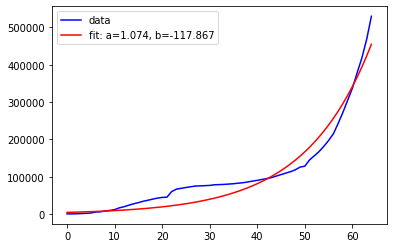

In [231]:
plot(xdata, ydata, 'b-', label='data')
plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
legend()

In [232]:
xdata[-1]

64

In [240]:
func(70,*popt)

698633.2936739209